Loading Dataset:

In [1]:
!git clone "https://github.com/muhammedtalo/COVID-19.git"

Cloning into 'COVID-19'...
remote: Enumerating objects: 1237, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 1237 (delta 27), reused 75 (delta 22), pack-reused 1156
Receiving objects: 100% (1237/1237), 400.89 MiB | 41.99 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Checking out files: 100% (1129/1129), done.


In [2]:
!mv "COVID-19/X-Ray Image DataSet" "."

In [3]:
!ls

 COVID-19   sample_data  'X-Ray Image DataSet'


Loading pretrained weights:

In [4]:
!git clone "https://github.com/arnoweng/CheXNet.git"

Cloning into 'CheXNet'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 62 (delta 6), reused 5 (delta 5), pack-reused 52
Unpacking objects: 100% (62/62), done.


In [5]:
!mv "./CheXNet/model.pth.tar" "."

In [6]:
!ls

 CheXNet   COVID-19   model.pth.tar   sample_data  'X-Ray Image DataSet'


In [21]:
DATASET_ROOT = 'X-Ray Image DataSet'
CKPT_PATH = 'model.pth.tar'

Importing from libraries:

In [22]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import re

import numpy as np
import pandas as pd
import time

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torchvision.transforms.functional import InterpolationMode
from torchvision.datasets import VOCSegmentation
from torchvision import models

Imports from my code:

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setting seed:

In [24]:
torch.manual_seed(24)
np.random.seed(24)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Class for loading pretrained model:

In [26]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes, weights=True):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121()
        num_features = self.densenet121.classifier.in_features
        if weights:
            self.densenet121.classifier = nn.Sequential(
                nn.Linear(num_features, 14)
            )
            load_weights(self)
        self.densenet121.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.densenet121(x)
        return x


def load_weights(model, device='cpu'):
    # Code modified from torchvision densenet source for loading from pre .4 densenet weights.
    checkpoint = torch.load(CKPT_PATH, map_location=torch.device(device))
    state_dict = checkpoint['state_dict']
    remove_data_parallel = True  # Change if you don't want to use nn.DataParallel(model)

    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')
    for key in list(state_dict.keys()):
        match = pattern.match(key)
        new_key = match.group(1) + match.group(2) if match else key
        new_key = new_key[7:] if remove_data_parallel else new_key
        state_dict[new_key] = state_dict[key]
        # Delete old key only if modified.
        if match or remove_data_parallel:
            del state_dict[key]

    model.load_state_dict(state_dict)

Loading pretrained model:

In [27]:
model = DenseNet121(3).to(device)
model

DenseNet121(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

Dataset for loading images:

In [28]:
class CovidDataset(Dataset):
    def __init__(self, root, transform=None, shuffle=True):
        if not isinstance(root, Path):
            root = Path(root)
        self.root = root
        self.transform = transform
        data = []
        for y in os.listdir(self.root):
            for x in os.listdir(os.path.join(self.root, y)):
                data.append({'image': x, 'label': y})
        self.dataframe = pd.DataFrame(data)
        self.label_names, labels = np.unique(self.dataframe['label'], return_inverse=True)
        self.dataframe['label'] = labels
        self.label_counts = self.dataframe['label'].value_counts()
        self.label_weights = len(self.dataframe) / self.label_counts
        self.label_weights = self.label_weights / self.label_weights.sum()
        if shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        item = self.dataframe.loc[index]
        image_name, label = item['image'], item['label']
        label_name = self.label_names[label]
        image_path = self.root / label_name / image_name
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [29]:
normalize = T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])

# dataset = CovidDataset(DATASET_ROOT, transform=T.Compose([
#                                     T.Resize(256),
#                                     T.TenCrop(224),
#                                     T.Lambda
#                                     (lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops])),
#                                     T.Lambda
#                                     (lambda crops: torch.stack([normalize(crop) for crop in crops]))
#                                 ]))
dataset = CovidDataset(DATASET_ROOT,
                       transform=T.Compose([
                           T.Resize((256, 256)),
                           T.ToTensor(),
                           normalize
                       ]))

In [30]:
dataset.label_weights

1    0.166667
2    0.166667
0    0.666667
Name: label, dtype: float64

In [31]:
dataset[0][0].shape

torch.Size([3, 256, 256])

In [32]:
model(dataset[0][0].to(device).unsqueeze(0))

tensor([[-0.2601,  0.0560,  0.1023]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Dataloaders:

In [33]:
# splitting train and test sets
voc_len = len(dataset)
train_len = int(0.8 * voc_len)
test_len = voc_len - train_len
train_set, test_set = random_split(dataset, [train_len, test_len])

In [34]:
# splitting train and val sets
train_len = int(0.8 * len(train_set))
val_len = len(train_set) - train_len
train_set, val_set = random_split(train_set, [train_len, val_len])

In [35]:
train_loader = DataLoader(train_set, 64, shuffle=True)
val_loader = DataLoader(val_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

Training functions:

In [52]:
import time, tqdm


def train(model, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    N_train = len(train_loader.dataset)

    model.train()
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x, y) in pbar:
            optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            p = model(x)

            loss = criterion(p, y)
            train_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Train Loss: {train_loss / N_train:.3e}')

            loss.backward()
            optimizer.step()

    train_loss /= N_train
    return train_loss


def validate(model, val_loader, criterion, epoch=0, metrics=None):
    val_loss = 0
    N_val = len(val_loader.dataset)
    Y = []
    Y_pred = []
    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = model(x)
            y_pred = p.argmax(dim=-1)
            loss = criterion(p, y)
            val_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Val Loss: {val_loss / N_val:.3e}')
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    val_loss /= N_val
    if metrics is not None:
        return {metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()}
    return val_loss

In [37]:
train_losses, val_losses = list(), list()

In [61]:
def train_model(model, criterion, dataloaders, optimizer, num_epochs, model_name='pytorch_model'):
    val = len(dataloaders) == 2
    if val:
        train_loader, val_loader = dataloaders
    else:
        train_loader, = dataloaders

    val_loss_min = np.inf

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, epoch)
        train_losses.append(train_loss)
        if val:
            val_loss = validate(model, val_loader, criterion, epoch)
            val_losses.append(val_loss)

            if val_loss <= val_loss_min:
                torch.save(model.state_dict(), f'{model_name}.pt')
                val_loss_min = val_loss
        print('\n', '---' * 20)
    if val:
        # load best model during different epochs
        model.load_state_dict(torch.load(f'{model_name}.pt'))
        plt.plot(val_losses, label='val')

    plt.plot(train_losses, label='train')
    plt.legend()

    return model

Freezing pretrained layers:

In [39]:
model = model.to(device)
for param in model.parameters():
    param.requires_grad = False
for param in model.densenet121.classifier.parameters():
    param.requires_grad = True

Learning Config:

In [40]:
lr = 1e-4
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(dataset.label_weights.sort_index().tolist())).to(device)

Overfitting on a small dataset:

In [41]:
small_len = int(0.1 * len(train_set))
print(small_len)
other_len = len(train_set) - small_len
_, small_set = random_split(train_set, [other_len, small_len])
small_loader = DataLoader(small_set, 64, shuffle=True)

72


Epoch:29, Train Loss: 1.499e-01: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


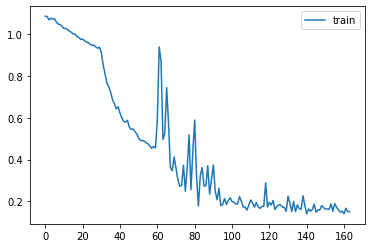

In [50]:
lr = 1e-5
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
train_model(model, criterion, [small_loader], optimizer, 30);

In [53]:
validate(model, small_loader, criterion, metrics={'accuracy': lambda y1, y2: (y1==y2).mean()})

Epoch:0, Val Loss: 1.434e-01: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


-------------------------------------------------------------------


{'accuracy': 0.9444444444444444}

Tuning hyper-parameters:

In [43]:
# todo!

Training model:

In [54]:
# reinitialize model and losses
train_losses, val_losses = list(), list()
model = DenseNet121(3).to(device)

Epoch:0, Val Loss: 4.944e-01: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]



-------------------------------------------------------------------


Epoch:1, Val Loss: 5.029e-01: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]



-------------------------------------------------------------------


Epoch:2, Val Loss: 5.214e-01: 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]



-------------------------------------------------------------------


Epoch:3, Val Loss: 4.932e-01: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]



-------------------------------------------------------------------


Epoch:4, Val Loss: 4.978e-01: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]



-------------------------------------------------------------------


Epoch:5, Val Loss: 5.009e-01: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]



-------------------------------------------------------------------


Epoch:6, Val Loss: 5.129e-01: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]



-------------------------------------------------------------------


Epoch:7, Val Loss: 5.151e-01: 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]



-------------------------------------------------------------------


Epoch:8, Val Loss: 5.085e-01: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]



-------------------------------------------------------------------


Epoch:9, Val Loss: 5.431e-01: 100%|██████████| 3/3 [00:04<00:00,  1.67s/it]



-------------------------------------------------------------------


Epoch:10, Val Loss: 5.241e-01: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]



-------------------------------------------------------------------


Epoch:11, Val Loss: 5.406e-01: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]



-------------------------------------------------------------------


Epoch:12, Val Loss: 4.938e-01: 100%|██████████| 3/3 [00:05<00:00,  1.93s/it]



-------------------------------------------------------------------


Epoch:13, Val Loss: 5.149e-01: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]



-------------------------------------------------------------------


Epoch:14, Val Loss: 5.246e-01: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]



-------------------------------------------------------------------


Epoch:15, Val Loss: 5.104e-01: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]



-------------------------------------------------------------------


Epoch:16, Val Loss: 5.042e-01: 100%|██████████| 3/3 [00:05<00:00,  1.81s/it]



-------------------------------------------------------------------


Epoch:17, Val Loss: 5.053e-01: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]



-------------------------------------------------------------------


Epoch:18, Val Loss: 5.212e-01: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]



-------------------------------------------------------------------


Epoch:19, Val Loss: 5.468e-01: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]



-------------------------------------------------------------------


Epoch:20, Val Loss: 5.230e-01: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]



-------------------------------------------------------------------


Epoch:21, Val Loss: 4.907e-01: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]



-------------------------------------------------------------------


Epoch:22, Val Loss: 5.151e-01: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]



-------------------------------------------------------------------


Epoch:23, Val Loss: 5.030e-01: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]



-------------------------------------------------------------------


Epoch:24, Val Loss: 5.096e-01: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]



-------------------------------------------------------------------


Epoch:25, Val Loss: 5.196e-01: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]



-------------------------------------------------------------------


Epoch:26, Val Loss: 5.020e-01: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]



-------------------------------------------------------------------


Epoch:27, Val Loss: 5.044e-01: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]



-------------------------------------------------------------------


Epoch:28, Val Loss: 5.331e-01: 100%|██████████| 3/3 [00:04<00:00,  1.58s/it]



-------------------------------------------------------------------


Epoch:29, Val Loss: 5.135e-01: 100%|██████████| 3/3 [00:04<00:00,  1.57s/it]



-------------------------------------------------------------------


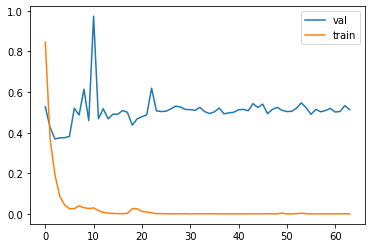

In [57]:
lr = 1e-6
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
model = train_model(model, criterion, [train_loader, val_loader], optimizer, 30, 'covid-classification');

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy)}

In [59]:
validate(model, test_loader, criterion, metrics=metrics)

Epoch:0, Val Loss: 4.035e-01: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


-------------------------------------------------------------------


{'accuracy': 0.8755555555555555,
 'precision': 0.9053116195973337,
 'recall': 0.8972110732285089,
 'f1': 0.9008532557646274}

In [60]:
from google.colab import files
files.download('covid-classification.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>